***Libraries***

In [1]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

# ***Code***

Preprocessing

In [2]:
# Load Data
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Gllbal Variables
IMG_SIZE= 224
BATCH_SIZE = 32

# Prerocessing Fanction
def formatEX(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


# Pipelines
FormatedTrain = ds_train.shuffle(1000).map(formatEX).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
FormatedTest = ds_test.map(formatEX).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [3]:
base_model = MobileNetV3Large(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True

Inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

DataAS = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomRotation(0.15),
    layers.RandomBrightness(0.1)
])

callback = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('DogClassificationModel.keras', monitor='val_accuracy', save_best_only=True)
]

x = DataAS(Inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

Outputs = layers.Dense(37, activation='softmax')(x)
model = tf.keras.Model(Inputs, Outputs)

for i in base_model.layers[:50]:
    i.trainable = False

model.compile(optimizer=tf.optimizers.Adam(2e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 37)             │        35,557 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,031,909 (11.57 MB)

 Trainable params: 2,980,093 (11.37 MB)

 Non-trainable params: 51,816 (202.41 KB)

In [4]:
history = model.fit(FormatedTrain, epochs=60, validation_data=FormatedTest, callbacks=callback)

Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 393ms/step - accuracy: 0.0280 - loss: 3.6843 - val_accuracy: 0.0253 - val_loss: 3.8767 - learning_rate: 2.0000e-04
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 371ms/step - accuracy: 0.0457 - loss: 3.5660 - val_accuracy: 0.0210 - val_loss: 3.9147 - learning_rate: 2.0000e-04
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 349ms/step - accuracy: 0.0807 - loss: 3.4442 - val_accuracy: 0.0237 - val_loss: 3.8623 - learning_rate: 2.0000e-04
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.1046 - loss: 3.3016 - val_accuracy: 0.0698 - val_loss: 3.6306 - learning_rate: 2.0000e-04
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - accuracy: 0.1299 - loss: 3.1399 - val_accuracy: 0.0916 - val_loss: 3.5041 - learning_rate: 2.0000e-04
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 331ms/step - accuracy: 0.1785 - loss: 3.0011 - val_accuracy: 0.1161 - val_loss: 3.3393 - learning_rate: 2.0000e-04
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 33

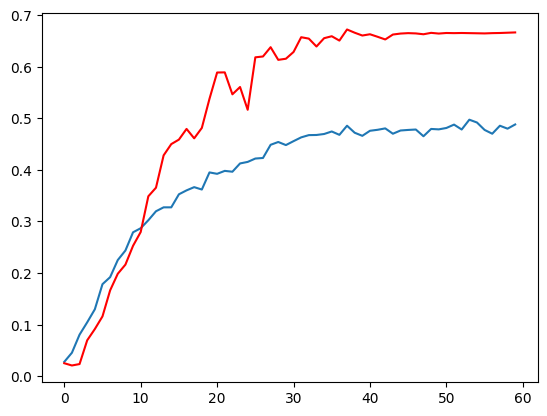

In [5]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='red')
plt.show()

In [6]:
model.evaluate(FormatedTest)

115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6664 - loss: 1.3188


[1.318787693977356, 0.6663941144943237]

***Model Testing***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


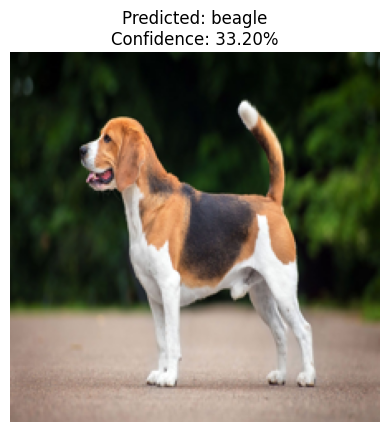

In [8]:
import requests
from io import BytesIO
import numpy as np
import PIL.Image as Image

def predict_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_array = (img_array / 127.5) - 1 
    img_array = np.expand_dims(img_array, axis=0) 
    
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    
    class_names = ds_info.features['label'].names
    plt.imshow(img_resized)
    plt.title(f"Predicted: {class_names[class_idx]}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

predict_from_url('https://cdn.britannica.com/16/234216-050-C66F8665/beagle-hound-dog.jpg')